In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi']= 150
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
batch_size = 20
seq_len = 7
num_features = 10
input_size = seq_len * num_features
hidden_size_1 = 128
hidden_size_2 = 256
hidden_size_3 = 128
output_size = 1

dropout = 0.5
learning_rate = 0.003
num_epochs = 400 

seed = np.random.randint(10000000, size = 1).item() #random seed

In [3]:
df = pd.read_csv('Farmgate all generated data for lstm.csv')
df.Date = pd.to_datetime(df.Date, format = '%m/%d/%Y')
df = df.set_index('Date')
df.head()

,SO2,NO2,CO,O3,PM2.5,Solar Rad,Rainfall,Temp,Humidity,Wind Speed,PM10
Date,,,,,,,,,,,
2013-01-01,10.990000,64.80,3.010000,7.770000,178.410000,183.69,0,17.0,69,0.0,515.3100
2013-01-02,13.410000,71.56,2.730000,7.780000,204.030000,203.27,0,18.4,68,2.0,473.8300
2013-01-03,10.870000,67.23,2.450000,6.910000,278.170000,188.48,0,18.9,74,0.0,462.5000
2013-01-04,12.870000,61.54,0.960000,20.990000,191.920000,251.45,0,19.9,70,2.0,402.0825
2013-01-05,15.033333,55.85,2.366667,19.496667,212.946667,362.78,0,18.7,60,2.0,341.6650


In [4]:
df_scaled = (df - df.mean())/ df.std()
df_scaled.head()

,SO2,NO2,CO,O3,PM2.5,Solar Rad,Rainfall,Temp,Humidity,Wind Speed,PM10
Date,,,,,,,,,,,
2013-01-01,0.213221,0.810917,1.061040,-0.115261,1.128015,-2.495260,-0.364317,-2.256193,-0.278817,-1.912226,2.972864
2013-01-02,0.407265,1.061810,0.840476,-0.114491,1.469793,-2.277708,-0.364317,-1.916256,-0.370281,-0.197390,2.637867
2013-01-03,0.203599,0.901105,0.619911,-0.181466,2.458844,-2.442038,-0.364317,-1.794850,0.178503,-1.912226,2.546365
2013-01-04,0.363966,0.689925,-0.553808,0.902442,1.308242,-1.742384,-0.364317,-1.552038,-0.187353,-0.197390,2.058427
2013-01-05,0.537429,0.478744,0.554267,0.787482,1.588745,-0.505406,-0.364317,-1.843412,-1.101992,-0.197390,1.570489


In [5]:
df_scaled.reset_index(inplace = True)
df_scaled = df_scaled.drop('Date', 1)
df_scaled.head()

,SO2,NO2,CO,O3,PM2.5,Solar Rad,Rainfall,Temp,Humidity,Wind Speed,PM10
0,0.213221,0.810917,1.061040,-0.115261,1.128015,-2.495260,-0.364317,-2.256193,-0.278817,-1.912226,2.972864
1,0.407265,1.061810,0.840476,-0.114491,1.469793,-2.277708,-0.364317,-1.916256,-0.370281,-0.197390,2.637867
2,0.203599,0.901105,0.619911,-0.181466,2.458844,-2.442038,-0.364317,-1.794850,0.178503,-1.912226,2.546365
3,0.363966,0.689925,-0.553808,0.902442,1.308242,-1.742384,-0.364317,-1.552038,-0.187353,-0.197390,2.058427
4,0.537429,0.478744,0.554267,0.787482,1.588745,-0.505406,-0.364317,-1.843412,-1.101992,-0.197390,1.570489


In [6]:
array = df_scaled.iloc[:,0:12].values
print(array.shape)

(2191, 11)


In [7]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences): break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[i:end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

# convert into input/output
X, y = split_sequences(array, seq_len)
X_array = np.array(X)
y_array = np.array(y)
print(X_array.shape) 
print(y_array.shape)

(2185, 7, 10)
(2185, 7)


In [8]:
Tens_X = torch.from_numpy(X_array)
Res_X = Tens_X.view(len(Tens_X), -1)

In [9]:
y_array[:, -1].shape

(2185,)

In [10]:
All_X = Res_X
All_y = torch.from_numpy(y_array[:, -1]).view(-1, 1)

print(All_X.shape)
print(All_y.shape)

torch.Size([2185, 70])
torch.Size([2185, 1])


In [11]:
class AirMeteoroDataset(Dataset):
    def __init__(self):
        self.len = All_X.shape[0]
        self.X_data = All_X
        self.y_data = All_y

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [12]:
dataset = AirMeteoroDataset()
#Dataset split

import math
def roundup(x, num):
    return int(math.ceil(x / num)) * num


train_size = roundup(round(len(dataset) * 0.6), batch_size) #should I try 0.7 too?
val_size = round((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset,[train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))

In [13]:
#making mini-batches for training set

train_loader = DataLoader(dataset = train_set,
                          batch_size = batch_size,
                          shuffle = True)

In [14]:
#model building

class Model(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size, p = 0.0):
        super(Model, self).__init__()
        
        #linear_layers
        self.linear1 = nn.Linear(in_features = input_size, out_features = hidden_size_1, bias = True)
        self.linear2 = nn.Linear(in_features = hidden_size_1, out_features = hidden_size_2, bias = True)
        self.linear3 = nn.Linear(in_features = hidden_size_2, out_features = hidden_size_3, bias = True)
        self.linear4 = nn.Linear(in_features = hidden_size_3, out_features = output_size, bias = True)
        
        #dropouts
        self.dropout = nn.Dropout(p = p)
        
        #activation
        self.relu = nn.ReLU()
        
        #batchnorm
        self.batchnorm1 = nn.BatchNorm1d(num_features = hidden_size_1)
        self.batchnorm2 = nn.BatchNorm1d(num_features = hidden_size_2)
        self.batchnorm3 = nn.BatchNorm1d(num_features = hidden_size_3)
        
        
    def forward(self, X):
        z1 = self.linear1(X)
        a1 = self.dropout(self.relu(self.batchnorm1(z1)))
        
        z2 = self.linear2(a1)
        a2 = self.dropout(self.relu(self.batchnorm2(z2)))
        
        z3 = self.linear3(a2)
        a3 = self.dropout(self.relu(self.batchnorm3(z3)))
        
        out = self.linear4(a3)
        return out
    

In [15]:
PM10_model = Model(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size, dropout).cuda().float()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(PM10_model.parameters(), lr = learning_rate)

In [16]:
#itertaion and learning parameters
all_test_loss = []
all_val_loss = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    PM10_model.train()
    for i, (X_data, y_data) in enumerate(train_loader):  

        X_data = X_data.cuda()
        y_data = y_data.cuda()

        # Forward pass
        outputs = PM10_model(X_data.float())
        loss = criterion(outputs, y_data.float())

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    if (epoch +1) % 50 == 0:
        print (f'Train loss after Epoch [{epoch+1}/{num_epochs}]: {loss.item():.6f}')

    all_test_loss.append(loss.item())

    X_val = torch.empty(0, 70).float().cuda()
    y_val = torch.empty(0,1).float().cuda()
    for i, (X_data, y_data) in enumerate(val_set):
        X_data = X_data.float().reshape(1,70).cuda()
        X_val = torch.cat((X_val, X_data), 0)

        y_data = y_data.float().reshape(1,1).cuda()
        y_val = torch.cat((y_val, y_data), 0)

    PM10_model.eval()

    with torch.no_grad():
        outputs = PM10_model(X_val).cuda()
        val_loss = criterion(outputs, y_val)
        all_val_loss.append(val_loss.item())

Train loss after Epoch [50/400]: 0.343900
Train loss after Epoch [100/400]: 0.283864
Train loss after Epoch [150/400]: 0.113132
Train loss after Epoch [200/400]: 0.193593
Train loss after Epoch [250/400]: 0.284062
Train loss after Epoch [300/400]: 0.269409
Train loss after Epoch [350/400]: 0.168785
Train loss after Epoch [400/400]: 0.226489


Text(0, 0.5, 'Loss')

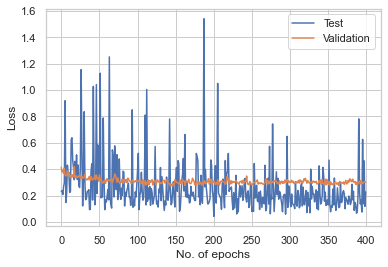

In [17]:
#test_val_plot     

plt.plot(list(range(0, num_epochs)), all_test_loss, label = 'Test')
plt.plot(list(range(0, num_epochs)), all_val_loss, label = 'Validation')
plt.legend(loc="upper right")
plt.xlabel('No. of epochs')
plt.ylabel('Loss')